In [1]:
require( readxl )
require( Cairo )


Loading required package: readxl
Loading required package: Cairo


In [3]:
# Create directories for output files

analysis_root <- "analysis" 
out_6_dir <- paste( analysis_root, "/labs-6-groups", sep="" )
out_3_dir <- paste( analysis_root, "/labs-3-groups", sep="" )

dir.create( analysis_root )
dir.create( out_6_dir )
dir.create( out_3_dir )


Warning message in dir.create(analysis_root):
“'analysis' already exists”

In [4]:
# Function to create a dataframe consisting of only the groups and columns of interest for this analysis
createGroupSubset <- function( h, grps ) {
    dd <- data.frame()
    
    # this will order the dataframe chronologically which gives the correct order for graphing
    tps <- c("BL", "EH", "MID REBOA", "END REBOA", "1 HR", "6 HR", "12 HR", "ES" )
    for( tp in tps ) {
        idx = which( colnames(h) == tp )
        if( length(idx) > 0 ) {
            f <- data.frame( animal_id=h$animal_id, group=h$group, TP=tp, val=h[idx][[1]] )
            if( nrow( dd ) == 0 ) {
                dd <- f
            } else {
                dd <- rbind( dd, f )
            }
        }
    }
    
    # remove any rows with a NA value
    subset( dd, !is.na( dd$val ) )
}

In [16]:
# Use the "aggregate" function to create a dataframe with group, timepoint, mean, and SD
createAggregateAnalysis <- function( dd ) {
    myAnalysis <- aggregate(dd$val,
        by = list(grp = dd$group, TP = dd$TP),
        FUN = function(x) c(mean = mean(x, na.rm=TRUE), sd = sd(x, na.rm = TRUE),
                        n = length(x[!is.na(x)]) ))
                        
    myAnalysis <- do.call(data.frame, myAnalysis)
    myAnalysis$se <- myAnalysis$x.sd / sqrt(myAnalysis$x.n)
    colnames(myAnalysis) <- c("grp", "TP", "mean", "sd", "n", "se")

    # The names column is used to label every bar
    myAnalysis$names <- as.character(myAnalysis$TP)
    
    # but we don't really want to label very bar, only the middle bar in each 
    # cluster of bars, so set the undesired names to ""
                        
    skip = trunc( (length(grps) + 1)/2 )
    for( idx in c(1:length(grps)) ) {
        if( idx != skip ) {
            idxs <- seq(idx, length(myAnalysis$names),length(grps))
            myAnalysis$names[ idxs ] <- ""
        }
    }
                        
    myAnalysis
}



In [34]:
makeOneAnalysisPlot <- function( myAnalysis, labName, y_min, y_max ) {
    
    tabbedMeans <- tapply(myAnalysis$mean, list(myAnalysis$grp,
                                      myAnalysis$TP),
                         function(x) c(x = x))
    
    barCenters <- barplot(height = tabbedMeans,
                      beside = TRUE, las = 1,
                      ylim = c(y_min, y_max), xpd=FALSE,
                      xaxt = "n",
                      main = "",
                      ylab = labName,
                      xlab = "",
                      border = "black", axes = TRUE,
                      legend.text = TRUE,
                      font=2, font.lab=2,
                      cex.lab=1.5,  # font expansion factor
                      args.legend = list(title = "Group", 
                                         x = "topright"
                                         ))

    # add standard-error-of-the-mean indicators to the graph

    tapply(myAnalysis$mean, list(myAnalysis$grp, myAnalysis$TP),
       function(x) c(x = x))    

    tabbedSE <- tapply(myAnalysis$se, list(myAnalysis$grp,
                                      myAnalysis$TP),
                         function(x) c(x = x))

                       	dy = (y_max - y_min) * 0.02
    text(x = barCenters, y = par("usr")[3] - dy, srt = 30, 
        adj = 1, labels = myAnalysis$names, xpd = TRUE, font=2, cex=1.3)

    segments(barCenters, tabbedMeans - tabbedSE, barCenters,
        tabbedMeans + tabbedSE, lwd = 1.5)

    arrows(barCenters, tabbedMeans - tabbedSE, barCenters,
        tabbedMeans + tabbedSE, lwd = 1.5, angle = 90,
        code = 3, length = 0.05)

    # tidy up the graph with a line on the bottom row
    abline(a = y_min, b = 0)

}

In [35]:

readAndPlotOneLab <- function( labName, y_min, y_max, grps ) {
    # read the data
    xls <- "data/labs.xlsx"
    h <- read_xlsx( xls, sheet=labName )

    # convert the group to factors, ordering the factors in chronological order
    h$group <- factor( h$group, levels=grps )

    dd <- createGroupSubset( h, grps )
    analysis <- createAggregateAnalysis( dd )
    makeOneAnalysisPlot( analysis, labName, y_min, y_max )
}

In [38]:
saveOneGraph <- function( destdir, labName, ... ) {
	fileName <- paste( destdir, "/", labName, ".png", sep="" )
	# png( file=fileName, width=800, height=600, units="px" )
	# par(mar = c(5, 6, 4, 5) + 0.1)
	# par(font=2)  # bold
	Cairo(file=fileName, 
      		type="png",
    		units="in", 
    		bg="white",
    		width=8, 
    		height=6, 
    		pointsize=11, 
    		res=150)
	par(mar = c(5, 8, 4, 5) + 0.1)
	par(font=2)
	readAndPlotOneLab( labName, ... )
	
	dev.off()
}
dev.off()
dev.off()
dev.off()
dev.off()


null device 
          1

ERROR: Error in dev.off(): cannot shut down device 1 (the null device)


png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

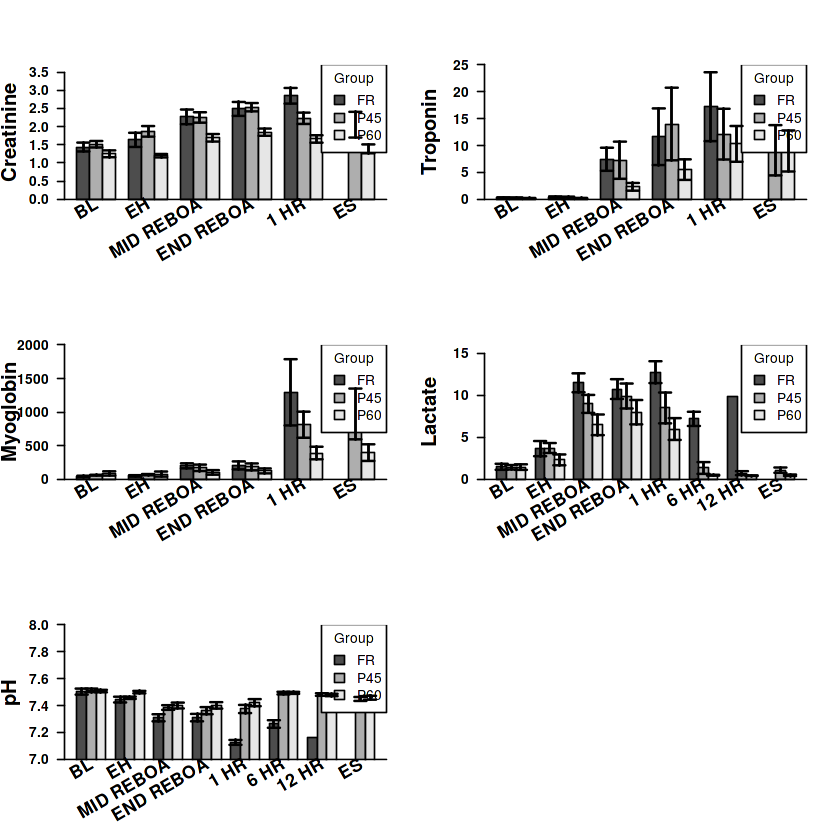

In [46]:
grps=c("FR","P45","P60")
destdir <- out_3_dir

par( mfrow=c(3,2))
readAndPlotOneLab( "Creatinine", 0, 3.7, grps)
readAndPlotOneLab( "Troponin", 0, 25, grps)
readAndPlotOneLab( "Myoglobin", 0, 2000, grps)
readAndPlotOneLab( "Lactate", 0, 16, grps)
readAndPlotOneLab( "pH", 7.0, 8.0, grps)

saveOneGraph(destdir, "Creatinine", 0, 3.7, grps)
saveOneGraph(destdir, "Troponin", 0, 25, grps)
saveOneGraph(destdir, "Myoglobin", 0, 2000, grps)
saveOneGraph(destdir, "Lactate", 0, 16, grps)
saveOneGraph(destdir, "pH", 7.0, 8.0, grps)